# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [61]:
# Install the required libraries
!pip install prophet

In [62]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [63]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True,
    date_format='%Y-%m-%d %H:%M:%S'
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

,Search Trends
Date,
6/1/16 0:00,97
6/1/16 1:00,92
6/1/16 2:00,76
6/1/16 3:00,60
6/1/16 4:00,38


,Search Trends
Date,
9/7/20 20:00,71
9/7/20 21:00,83
9/7/20 22:00,96
9/7/20 23:00,97
9/8/20 0:00,96


In [64]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37106 entries, 6/1/16 0:00 to 9/8/20 0:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8+ KB


/var/folders/c8/hb7hmlv175g9v_61s_1mf8xh0000gn/T/ipykernel_16392/2717610025.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index)


Dataset date range:
Start date: 2016-06-01 00:00:00
End date: 2020-09-08 00:00:00

Number of entries for May 2020: 744


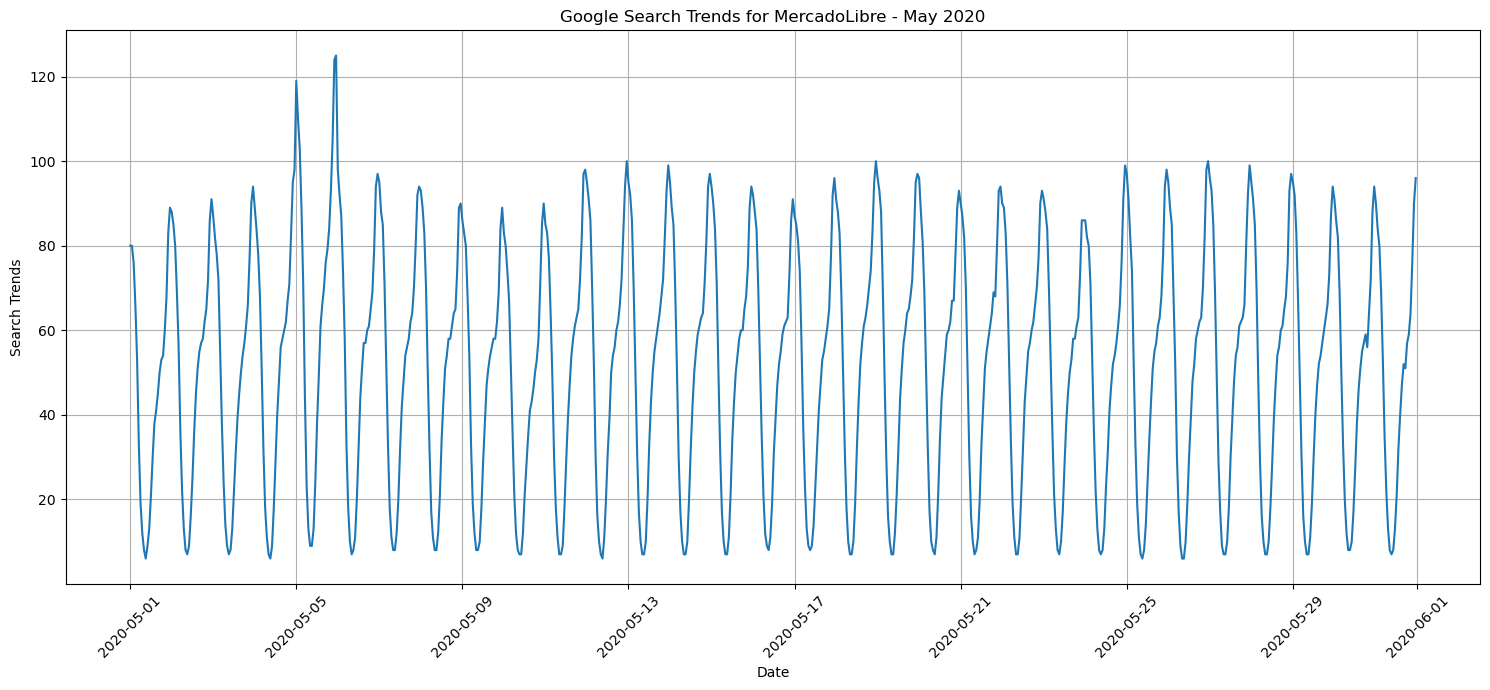

In [65]:
# Convert the index to datetime format 
df_mercado_trends.index = pd.to_datetime(df_mercado_trends.index)

# Check the date range of our data
print("Dataset date range:")
print("Start date:", df_mercado_trends.index.min())
print("End date:", df_mercado_trends.index.max())

# Slice the DataFrame to just the month of May 2020
may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Check if we have data
print(f"\nNumber of entries for May 2020: {len(may_2020)}")

# Plot to visualize the data for May 2020
if len(may_2020) > 0:
    # Fix the matplotlib error by using pyplot correctly
    fig = plt.figure(figsize=(15, 7))
    plt.plot(may_2020.index, may_2020['Search Trends'])
    plt.title('Google Search Trends for MercadoLibre - May 2020')
    plt.xlabel('Date')
    plt.ylabel('Search Trends')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for May 2020.")
    # Get a list of all available months in the dataset
    all_months = df_mercado_trends.index.strftime('%Y-%m').unique()
    print(f"Available months: {sorted(all_months)[-10:]}")  # Last 10 months in dataset

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [66]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = may_2020['Search Trends'].sum()

# View the traffic_may_2020 value
print(f"Total search traffic for May 2020: {traffic_may_2020}")

Total search traffic for May 2020: 38181


In [67]:
# Calculate the monthly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends['Search Trends'].resample('ME').sum().median()

# View the median_monthly_traffic value
print(f"Median monthly search traffic: {median_monthly_traffic}")


Median monthly search traffic: 35172.5


In [68]:
# Compare the search traffic for the month of May 2020 to the overall monthly median value
may_2020_vs_median = traffic_may_2020/median_monthly_traffic
print(f"Ratio of May 2020 traffic to median monthly traffic: {may_2020_vs_median:.2f}")

# Calculate the percentage difference
percentage_difference = (may_2020_vs_median - 1) * 100
print(f"May 2020 traffic was {percentage_difference:.2f}% {'higher' if percentage_difference > 0 else 'lower'} than the median monthly traffic")


Ratio of May 2020 traffic to median monthly traffic: 1.09
May 2020 traffic was 8.55% higher than the median monthly traffic


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, It was 8.55% higher than the monthly median.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

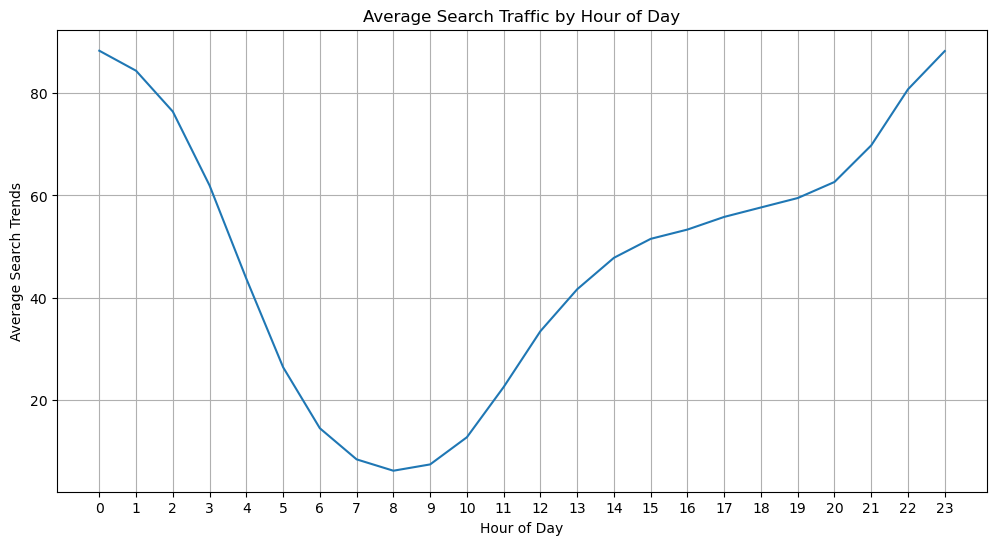

In [69]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plot the average traffic by hour of day
plt.figure(figsize=(12, 6))
hourly_traffic.plot(kind='line')
plt.title('Average Search Traffic by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Trends')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

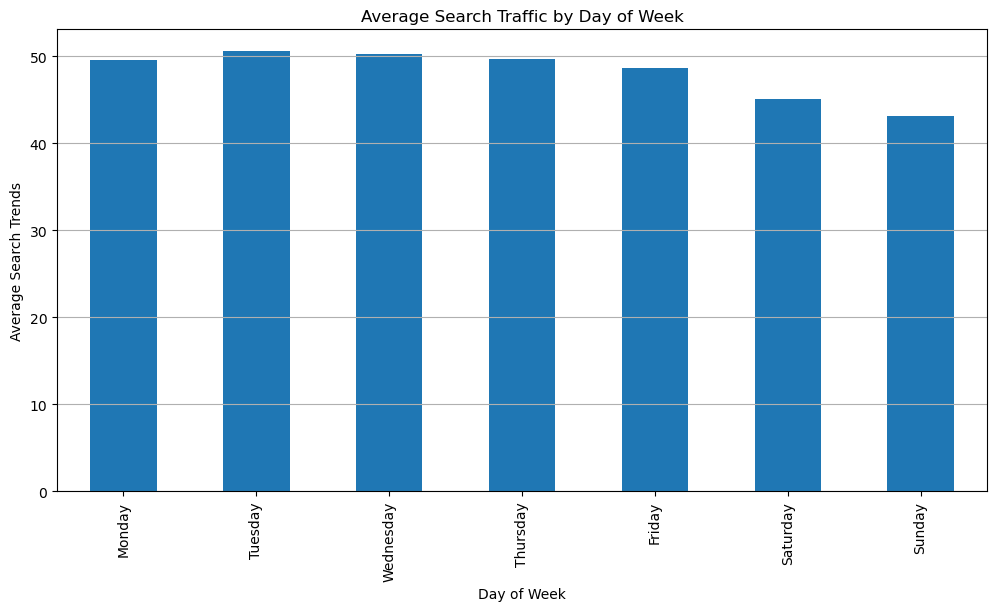

In [70]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.

day_of_week_traffic = df_mercado_trends.groupby(df_mercado_trends.index.dayofweek)['Search Trends'].mean()

# Create labels for the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the average traffic by day of week
plt.figure(figsize=(12, 6))
day_of_week_traffic.plot(kind='bar')
plt.title('Average Search Traffic by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Search Trends')
plt.xticks(range(7), days)
plt.grid(True, axis='y')
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

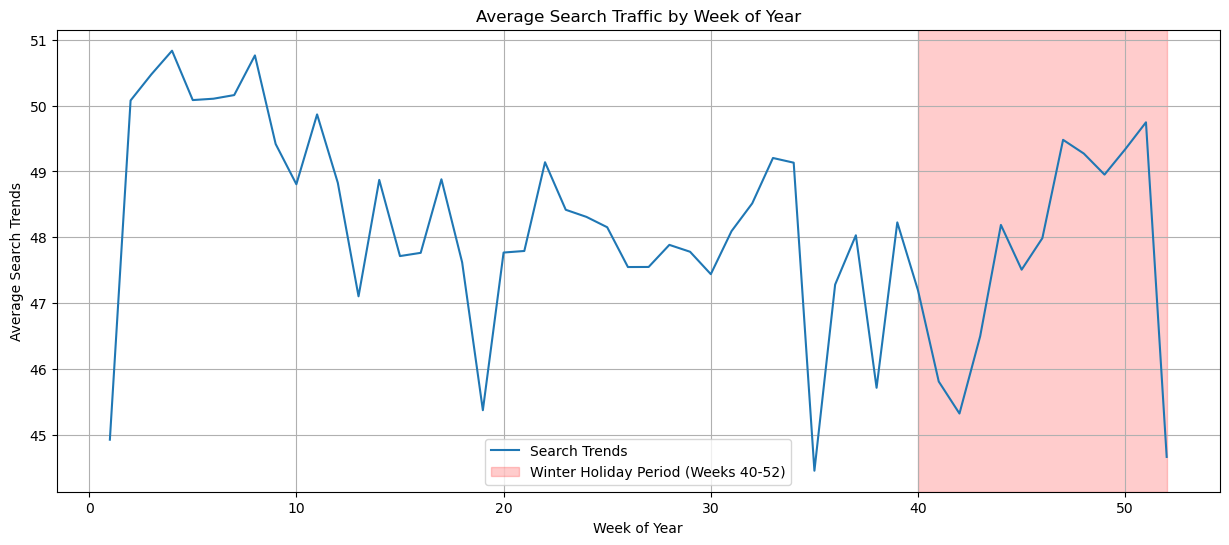

In [71]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.

week_of_year_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

# Plot the average traffic by week of year
plt.figure(figsize=(15, 6))
week_of_year_traffic.plot()
plt.title('Average Search Traffic by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Search Trends')
plt.axvspan(40, 52, color='red', alpha=0.2, label='Winter Holiday Period (Weeks 40-52)')
plt.legend()
plt.grid(True)
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** Hourly: Lowest search volume around 8am (GMT, so, middle of the night).  Day of week - lower search volume on weekends.  Seasonality- higher search in first 2-10 weeks of the year (high summer) - and also during holiday period.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [72]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


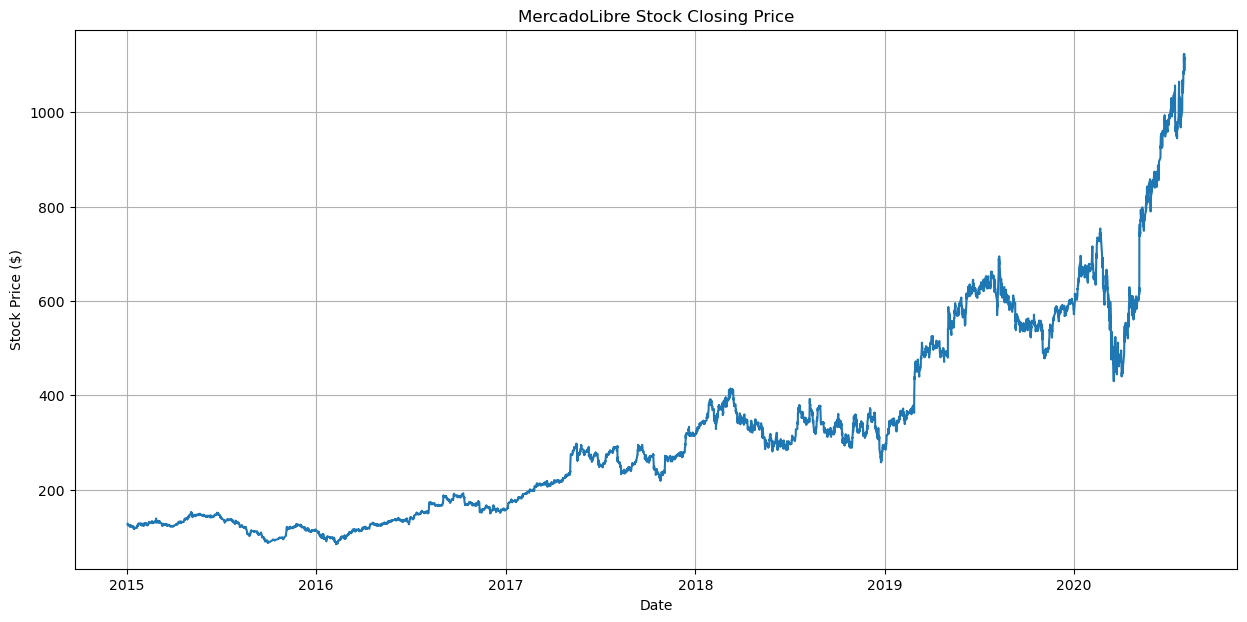

In [73]:
# Visualize the closing price of the df_mercado_stock DataFrame
plt.figure(figsize=(15, 7))
plt.plot(df_mercado_stock['close'])
plt.title('MercadoLibre Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.grid(True)
plt.show()

In [74]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop any rows with only one column of data
df_mercado = pd.concat([df_mercado_trends, df_mercado_stock], axis=1).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado.head())
display(df_mercado.tail())


,Search Trends,close
2016-06-01 09:00:00,6.0,135.16
2016-06-01 10:00:00,12.0,136.63
2016-06-01 11:00:00,22.0,136.56
2016-06-01 12:00:00,33.0,136.42
2016-06-01 13:00:00,40.0,136.10


,Search Trends,close
2020-07-31 11:00:00,20.0,1105.780
2020-07-31 12:00:00,32.0,1087.925
2020-07-31 13:00:00,41.0,1095.800
2020-07-31 14:00:00,47.0,1110.650
2020-07-31 15:00:00,53.0,1122.510


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [75]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_mercado.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame

display(first_half_2020.head())
display(first_half_2020.tail())

,Search Trends,close
2020-01-02 09:00:00,9.0,601.085
2020-01-02 10:00:00,14.0,601.290
2020-01-02 11:00:00,25.0,615.410
2020-01-02 12:00:00,37.0,611.400
2020-01-02 13:00:00,50.0,611.830


,Search Trends,close
2020-06-30 11:00:00,17.0,976.17
2020-06-30 12:00:00,27.0,977.50
2020-06-30 13:00:00,37.0,973.23
2020-06-30 14:00:00,45.0,976.50
2020-06-30 15:00:00,51.0,984.93


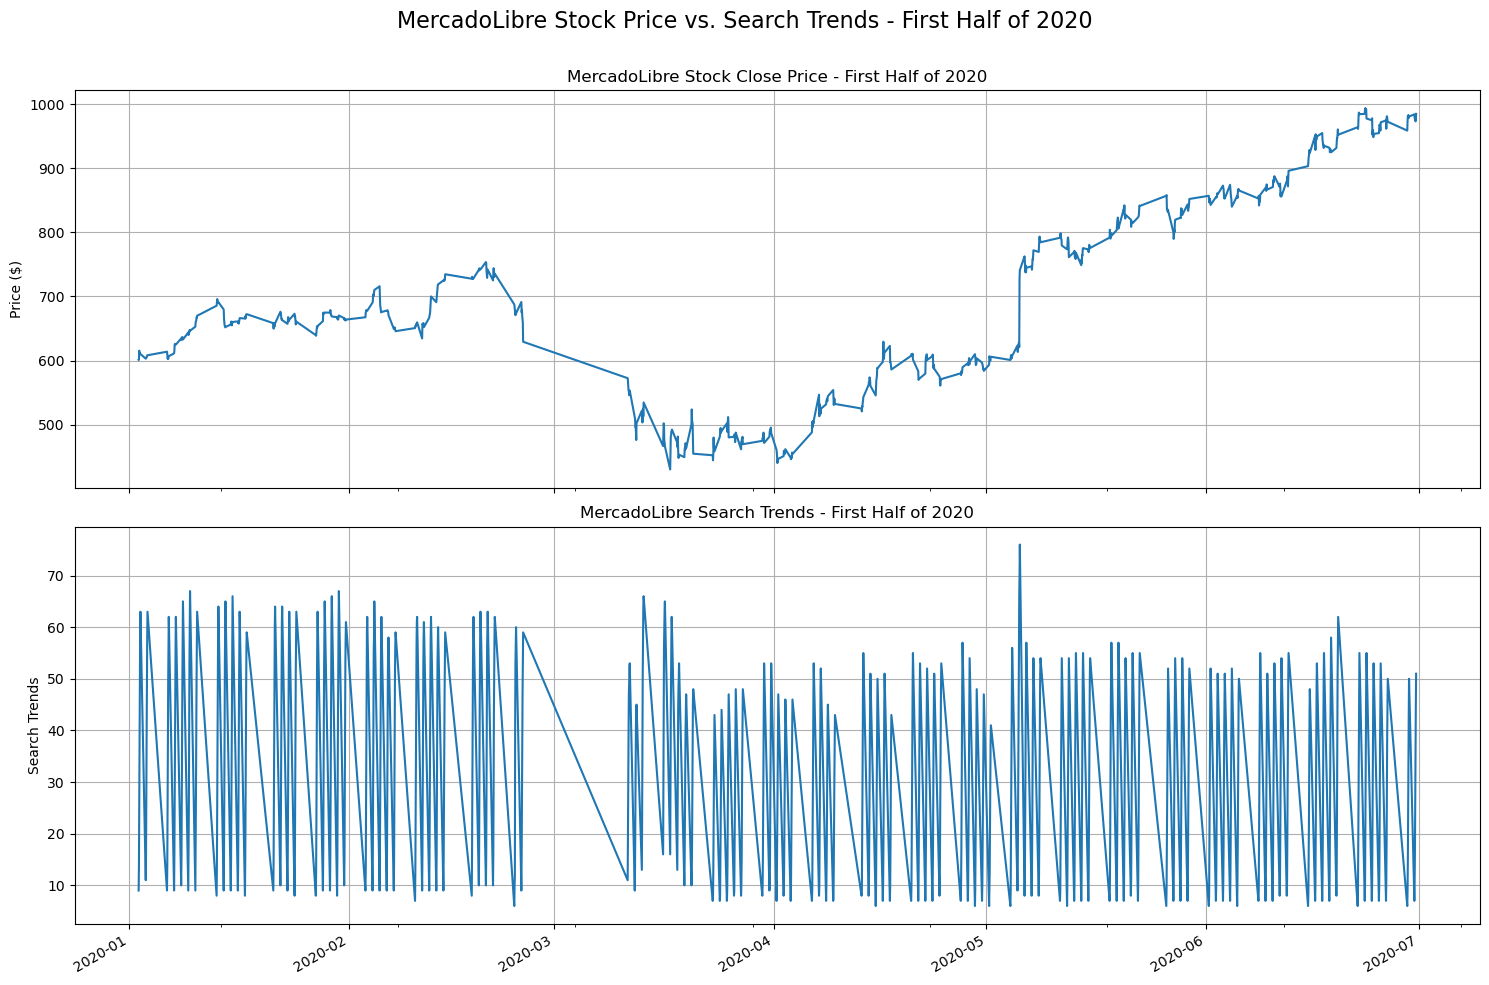

In [76]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Plot close price on first subplot
first_half_2020['close'].plot(ax=axes[0], title='MercadoLibre Stock Close Price - First Half of 2020')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True)

# Plot search trends on second subplot
first_half_2020['Search Trends'].plot(ax=axes[1], title='MercadoLibre Search Trends - First Half of 2020')
axes[1].set_ylabel('Search Trends')
axes[1].grid(True)

# Add a main title and adjust layout
plt.suptitle('MercadoLibre Stock Price vs. Search Trends - First Half of 2020', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** The stock price graph clearly shows a decline during the 'shutdown' phase of the pandemic, with a strong rebound and continued increase in May and June 2020.  The search volume graph also shows an initial decline during the shutdown, but the returns to normal levels and patterns, with one notable spike in early May. 

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [77]:
# Create a new column in the df_mercado DataFrame called Lagged Search Trends
df_mercado['Lagged Search Trends'] = df_mercado['Search Trends'].shift(1)

# Display the first few rows to verify the new column was created correctly
df_mercado[['Search Trends', 'Lagged Search Trends']].head()


,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,6.0,NaN
2016-06-01 10:00:00,12.0,6.0
2016-06-01 11:00:00,22.0,12.0
2016-06-01 12:00:00,33.0,22.0
2016-06-01 13:00:00,40.0,33.0


In [78]:
# Create a new column in the df_mercado DataFrame called Stock Volatility
df_mercado['Stock Volatility'] = df_mercado['close'].pct_change().rolling(window=4).std()

# Display the first few rows to verify the new column was created correctly
df_mercado[['close', 'Stock Volatility']].head(10)

,close,Stock Volatility
2016-06-01 09:00:00,135.16,NaN
2016-06-01 10:00:00,136.63,NaN
2016-06-01 11:00:00,136.56,NaN
2016-06-01 12:00:00,136.42,NaN
2016-06-01 13:00:00,136.10,0.006134
2016-06-01 14:00:00,137.03,0.004137
2016-06-01 15:00:00,136.27,0.005257
2016-06-02 09:00:00,136.00,0.005309
2016-06-02 10:00:00,136.83,0.006091
2016-06-02 11:00:00,136.22,0.005265


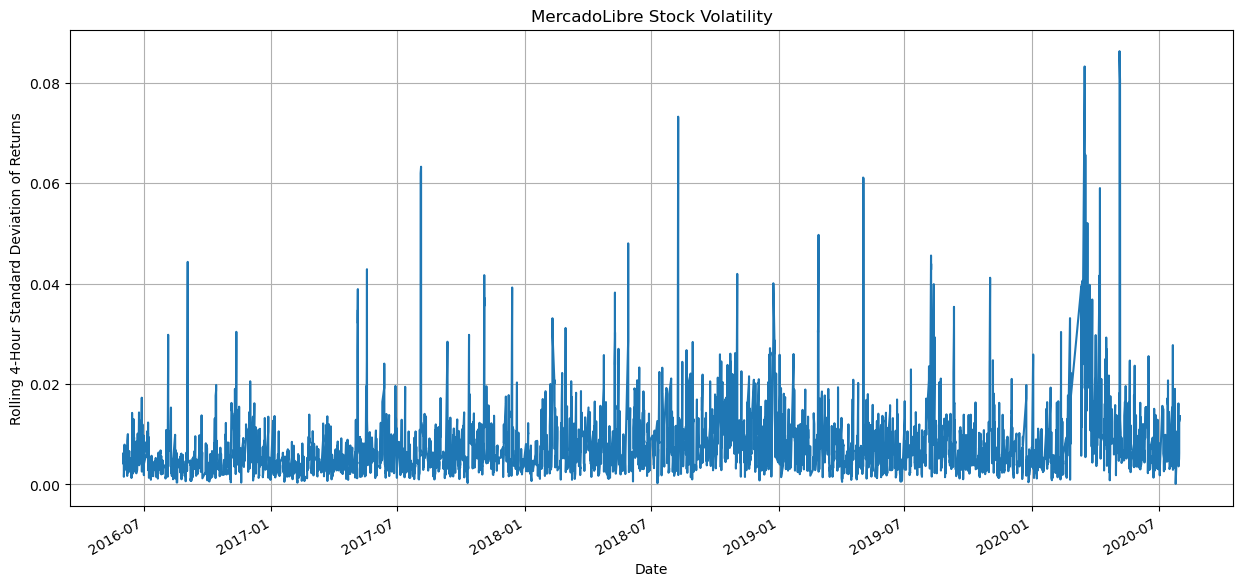

In [79]:
# Visualize the stock volatility
plt.figure(figsize=(15, 7))
df_mercado['Stock Volatility'].plot()
plt.title('MercadoLibre Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Rolling 4-Hour Standard Deviation of Returns')
plt.grid(True)
plt.show()

**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [80]:
# Create a new column in the df_mercado DataFrame called Hourly Stock Return
df_mercado['Hourly Stock Return'] = df_mercado['close'].pct_change() * 100

# Display the first few rows to verify the new column was created correctly
df_mercado[['close', 'Hourly Stock Return']].head(10)

,close,Hourly Stock Return
2016-06-01 09:00:00,135.16,NaN
2016-06-01 10:00:00,136.63,1.087600
2016-06-01 11:00:00,136.56,-0.051233
2016-06-01 12:00:00,136.42,-0.102519
2016-06-01 13:00:00,136.10,-0.234570
2016-06-01 14:00:00,137.03,0.683321
2016-06-01 15:00:00,136.27,-0.554623
2016-06-02 09:00:00,136.00,-0.198136
2016-06-02 10:00:00,136.83,0.610294
2016-06-02 11:00:00,136.22,-0.445809


In [81]:
# View the first and last five rows of the df_mercado DataFrame
display(df_mercado.head())
display(df_mercado.tail())

,Search Trends,close,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,6.0,135.16,NaN,NaN,NaN
2016-06-01 10:00:00,12.0,136.63,6.0,NaN,1.087600
2016-06-01 11:00:00,22.0,136.56,12.0,NaN,-0.051233
2016-06-01 12:00:00,33.0,136.42,22.0,NaN,-0.102519
2016-06-01 13:00:00,40.0,136.10,33.0,0.006134,-0.234570


,Search Trends,close,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,20.0,1105.780,11.0,0.012837,0.637986
2020-07-31 12:00:00,32.0,1087.925,20.0,0.013549,-1.614697
2020-07-31 13:00:00,41.0,1095.800,32.0,0.013295,0.723855
2020-07-31 14:00:00,47.0,1110.650,41.0,0.013001,1.355174
2020-07-31 15:00:00,53.0,1122.510,47.0,0.013566,1.067843


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [82]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
df_mercado[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Based on the correlation analysis, there does not appear to be a strong predictable relationship between lagged search traffic and either stock volatility or hourly stock returns.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [83]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df = prophet_df.rename(columns={'Date': 'ds', 'Search Trends': 'y'})

# Drop any NaN values from the prophet_df DataFrame
prophet_df = prophet_df.dropna()

# View the first and last five rows of the prophet_df DataFrame
print("First five rows:")
display(prophet_df.head())
print("\nLast five rows:")
display(prophet_df.tail())


First five rows:


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38



Last five rows:


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [84]:
# Call the Prophet function, store as an object
model = Prophet()


In [85]:
# Fit the time-series model
model.fit(prophet_df)

21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:48 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='h')

# View the last five rows of the future_mercado_trends DataFrame
future_mercado_trends.tail()


,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [87]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
forecast_mercado_trends.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.129250,81.570714,97.369787,44.129250,44.129250,45.429305,45.429305,45.429305,41.452726,...,1.860133,1.860133,1.860133,2.116445,2.116445,2.116445,0.0,0.0,0.0,89.558555
1,2016-06-01 01:00:00,44.130313,77.887786,94.543993,44.130313,44.130313,41.875073,41.875073,41.875073,37.943506,...,1.810049,1.810049,1.810049,2.121518,2.121518,2.121518,0.0,0.0,0.0,86.005386
2,2016-06-01 02:00:00,44.131375,67.202892,84.534332,44.131375,44.131375,31.551566,31.551566,31.551566,27.656533,...,1.768474,1.768474,1.768474,2.126559,2.126559,2.126559,0.0,0.0,0.0,75.682942
3,2016-06-01 03:00:00,44.132438,51.453100,69.529418,44.132438,44.132438,16.284352,16.284352,16.284352,12.417280,...,1.735502,1.735502,1.735502,2.131569,2.131569,2.131569,0.0,0.0,0.0,60.416789
4,2016-06-01 04:00:00,44.133500,35.292685,51.672983,44.133500,44.133500,-0.830504,-0.830504,-0.830504,-4.678139,...,1.711088,1.711088,1.711088,2.136547,2.136547,2.136547,0.0,0.0,0.0,43.302997


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

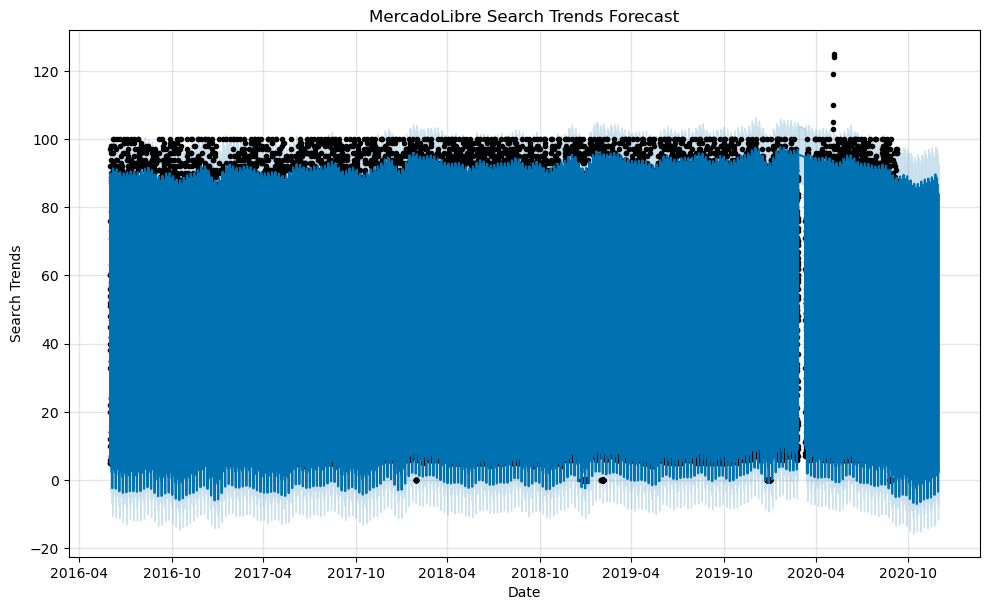

In [88]:
# Plot the Prophet predictions for the Mercado trends data
fig1 = model.plot(forecast_mercado_trends)
plt.title('MercadoLibre Search Trends Forecast')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**  Based on the forecast graph, the near-term forecast for MercadoLibre's popularity shows a slight downward trend. The blue line (representing the forecasted search trends) appears to decrease gradually in the most recent portion of the forecast period.
The graph shows that historically, MercadoLibre's search trends have been relatively stable, oscillating around a value of approximately 90-100. However, as we move into the forecast period (the rightmost portion of the graph), there is a visible decline in the predicted search traffic.
The confidence interval (the light blue shaded area) widens as we move further into the future, indicating increasing uncertainty in the predictions. Despite this uncertainty, the central forecast line shows a consistent downward trajectory in the near term.
This suggests that, according to the Prophet model, MercadoLibre may experience a moderate decrease in search popularity in the immediate future.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [89]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends = forecast_mercado_trends.set_index('ds')

# View only the yhat, yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head()

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,81.570714,97.369787
2016-06-01 01:00:00,86.005386,77.887786,94.543993
2016-06-01 02:00:00,75.682942,67.202892,84.534332
2016-06-01 03:00:00,60.416789,51.453100,69.529418
2016-06-01 04:00:00,43.302997,35.292685,51.672983


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

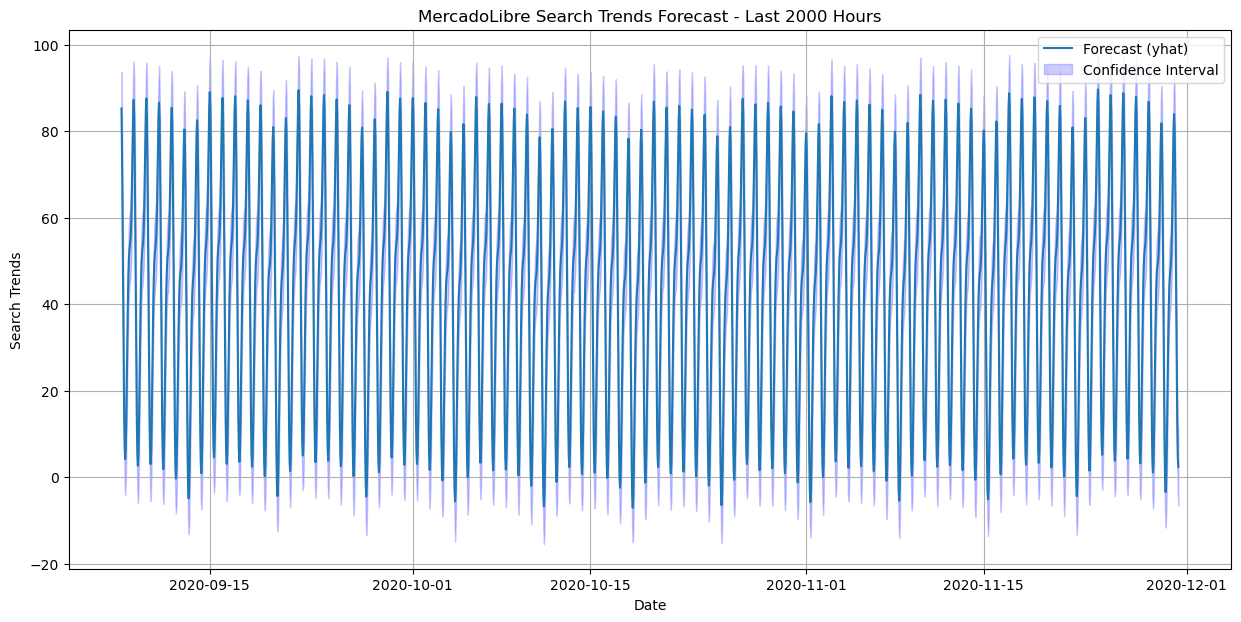

In [90]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
forecast_last_2000 = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-2000:]

plt.figure(figsize=(15, 7))
plt.plot(forecast_last_2000.index, forecast_last_2000['yhat'], label='Forecast (yhat)')
plt.fill_between(forecast_last_2000.index, 
                 forecast_last_2000['yhat_lower'], 
                 forecast_last_2000['yhat_upper'], 
                 color='blue', alpha=0.2, label='Confidence Interval')
plt.title('MercadoLibre Search Trends Forecast - Last 2000 Hours')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.legend()
plt.grid(True)
plt.show()


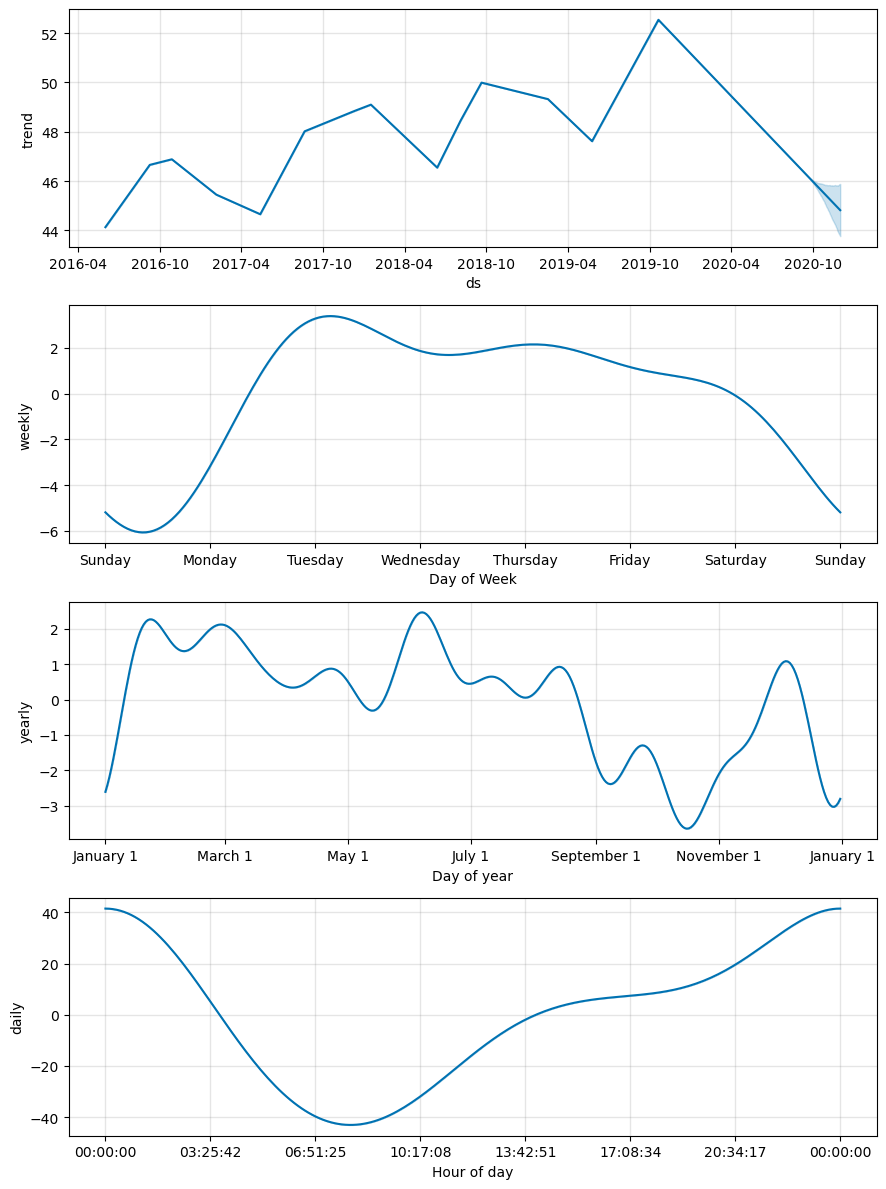

In [91]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends = forecast_mercado_trends.reset_index()

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
fig = model.plot_components(forecast_mercado_trends)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** Midnight (GMT) - so afterwork/evening in Latin America

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** Late October.
